In [52]:
import numpy as np
from matplotlib import pyplot as plt
import cvxpy as cp

plt.rcParams.update({'font.size': 14})

Constants

In [53]:
n = 2
m = 6
p = 1
q = 1

Step size $\alpha_k = \dfrac{2}{(k+1)^{0.6}}$

In [54]:
def step(k):
    return 2 / ((k+1)**(0.6))

Communication graph (period = 4)

![image.png](attachment:image.png)

Adjacency matrices

In [55]:
E0 = np.array([[1, 1, 1, 1, 0, 1],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 1, 0, 1, 0],
               [1, 0, 0, 0, 0, 1]])

In [56]:
E1 = np.array([[1, 1, 1, 0, 0, 0],
               [1, 1, 0, 0, 0, 1],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 1, 0],
               [0, 0, 0, 1, 0, 1]])

In [57]:
E2 = np.array([[1, 0, 0, 0, 0, 0],
               [1, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 1, 1, 1, 0, 0],
               [1, 0, 0, 0, 1, 1],
               [0, 0, 0, 1, 0, 1]])

In [58]:
E3 = np.array([[1, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 1],
               [1, 0, 0, 1, 0, 0],
               [0, 0, 1, 0, 1, 0],
               [0, 0, 1, 0, 1, 1]])

In [59]:
def E(k):
    if k % 4 == 0:
        return E0.T
    elif k % 4 == 1:
        return E1.T
    elif k % 4 == 2:
        return E2.T
    elif k % 4 == 3:
        return E3.T

Objective functions and constraints

In [60]:
a = np.array([[0.4, 0.4],
              [0.7, 0.6],
              [0.8, 0.4],
              [0.2, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])

b = np.array([-5, 3, 0, -7, 6, -8])

c = np.array([0.1, 0.8, 0.3, 0.6, 1, 0.4])

d = np.array([[0.2, 0.3],
              [0.8, 0.5],
              [0.8, 0.4],
              [0.3, 0],
              [0.7, 0.4],
              [0.5, 0.6]])

alpha = np.array([0.1, 0.3, 0.8, 0.7, 0.1, 0.1])

beta = np.array([-0.1, -0.6, -0.1, -0.1, -0.1, -0.1])

gamma = np.array([[0.8, 0.4],
                  [0.1, -0.6],
                  [-0.6, -0.8],
                  [0.8, 0.4],
                  [0.1, -0.4],
                  [-0.7, 0.2]])

delta = np.array([0.5, -0.3, -0.2, -0.1, -0.4, 0.2])

In [61]:
def f(i, x):
    return a[i] @ x + b[i] + c[i] * np.log(1 + np.exp(d[i] @ x))

def h1(i, x):
    return alpha[i] * np.linalg.norm(x) ** 2 + beta[i]

def h2(i, x):
    return gamma[i] @ x + delta[i]

def h(i, x):
    return np.array([h1(i, x), h2(i, x)])

def F(x):
    return np.sum([f(i, x) for i in range(m)])

Gossip matrices

In [62]:
def N_in(k, i):
    return np.sum(E(k)[i])

def N_out(k, j):
    return np.sum(E(k)[:, j])

In [63]:
def A(k):
    A = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if E(k)[i, j] == 1:
                A[i, j] = 1 / N_in(k, i)
    return A

def B(k):
    B = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if E(k)[i, j] == 1:
                B[i, j] = 1 / N_out(k, j)
    return B

In [64]:
E(1)

array([[1, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1]])

In [65]:
N_in(1, 2)

2

In [66]:
A(1)

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0.5]])

In [117]:
def grad_f(i, x):
    return a[i] + ((np.exp(d[i] @ x) * c[i]) / (1 + np.exp(d[i] @ x))) * d[i]

def grad_h1(i, x):
    return 2 * alpha[i] * x

def grad_h2(i, x):
    return gamma[i]

def grad_h(i, x):
    return np.vstack((grad_h1(i, x), grad_h2(i, x)))

Projections

In [118]:
def P_cut(a, b, c):
    if c < a:
        return a
    elif a <= c <= b:
        return c
    elif c > b:
        return b

In [119]:
def P_X(x):
    return np.array([P_cut(-3, 3, x[0]), P_cut(-3, 3, x[1])])

In [120]:
def P_Q(lmbd):
    p1 = lmbd[0] if lmbd[0] >= 0 else 0
    p2 = lmbd[1]
    return np.array([p1, p2])

# Gossip GD

In [90]:
def GossipGD(n_iter, x0):
    k = 0
    x_k = np.zeros((n_iter, m, 2))
    v_k = np.zeros((n_iter, m, 2))
    
    x_k[0] = x0

    while k <= n_iter-2:
        v_k[k] = A(k) @ x_k[k]
        for i in range(m):
            x_k[k+1][i] = P_X(v_k[k][i] - step(k) * grad_f(i, x_k[k][i]))
        k = k+1
    
    return x_k

In [130]:
n_iter = 100
x0 = np.zeros((6, 2))

In [131]:
x_k = GossipGD(n_iter, x0)

Last iteration

In [132]:
x_k[-1]

array([[-3., -3.],
       [-3., -3.],
       [-3., -3.],
       [-3., -3.],
       [-3., -3.],
       [-3., -3.]])

Some plots :(

Text(0, 0.5, '$\\| x_i^k - x^* \\|$')

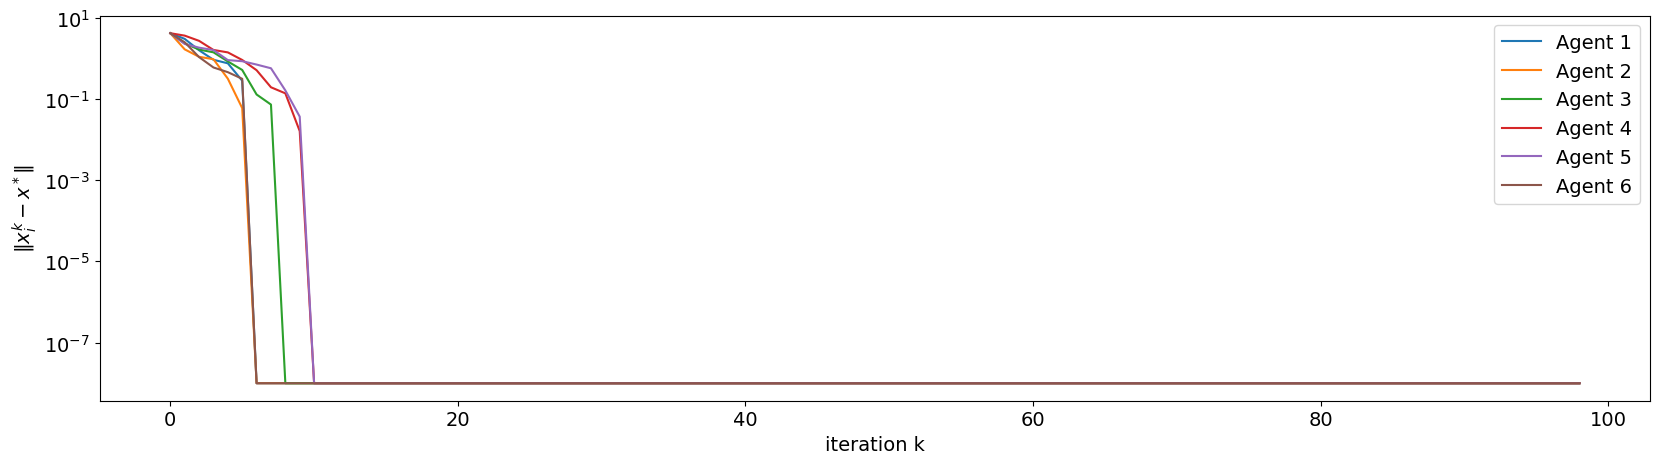

In [133]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(x_k.shape[0]-1), [np.linalg.norm(x_k[k][i] - x_opt) for k in range(x_k.shape[0]-1)], label=f"Agent {i+1}")
    
#plt.xlim(0, 100)
plt.yscale('log')
plt.legend()
#plt.title("Primal variable")
plt.xlabel("iteration k")
plt.ylabel("$\| x_i^k - x^* \|$")

Solving via CVXPY

In [43]:
x = cp.Variable(2)

f0 = a[0] @ x + b[0] + c[0] * cp.logistic(d[0] @ x)
f1 = a[1] @ x + b[1] + c[1] * cp.logistic(d[1] @ x)
f2 = a[2] @ x + b[2] + c[2] * cp.logistic(d[2] @ x)
f3 = a[3] @ x + b[3] + c[3] * cp.logistic(d[3] @ x)
f4 = a[4] @ x + b[4] + c[4] * cp.logistic(d[4] @ x)
f5 = a[5] @ x + b[5] + c[5] * cp.logistic(d[5] @ x)
f = f0 + f1 + f2 + f3 + f4 + f5

obj = cp.Minimize(f)

constraints = [x[0] >= -3,
               x[0] <= 3,
               x[1] >= -3,
               x[1] <= 3]

prob = cp.Problem(obj, constraints)

In [44]:
prob.solve()

-27.50034040306943

In [45]:
x.value

array([-2.99999999, -2.99999999])

In [46]:
x_opt = x.value

In [47]:
prob.value

-27.50034040306943

# Gradient Tracking

In [134]:
def GradientTracking(n_iter, x0):
    k = 0

    x_k = np.zeros((n_iter, m, 2))
    v_k = np.zeros((n_iter, m, 2))

    x_k[0] = x0

    y_k = np.zeros((n_iter, m, 2))
    z_k = np.zeros((n_iter, m, 2))
    
    for i in range(m):
        y_k[0][i] = grad_f(i, x_k[0][i])

    while k <= n_iter-2:
        
        for i in range(m):
            v_k[k][i] = P_X(x_k[k][i] - step(k) * y_k[k][i])

        x_k[k+1] = A(k) @ v_k[k]

        for i in range(m):
            z_k[k][i] = y_k[k][i] + grad_f(i, x_k[k+1][i]) - grad_f(i, x_k[k][i])

        y_k[k+1] = B(k) @ z_k[k]

        k = k+1
    
    return x_k

In [139]:
n_iter = 100
x0 = np.zeros((6, 2))

In [140]:
x_k = GradientTracking(n_iter, x0)

Last iteration

In [141]:
x_k[-1]

array([[-3., -3.],
       [-3., -3.],
       [-3., -3.],
       [-3., -3.],
       [-3., -3.],
       [-3., -3.]])

Some plots :(

Text(0, 0.5, '$\\| x_i^k - x^* \\|$')

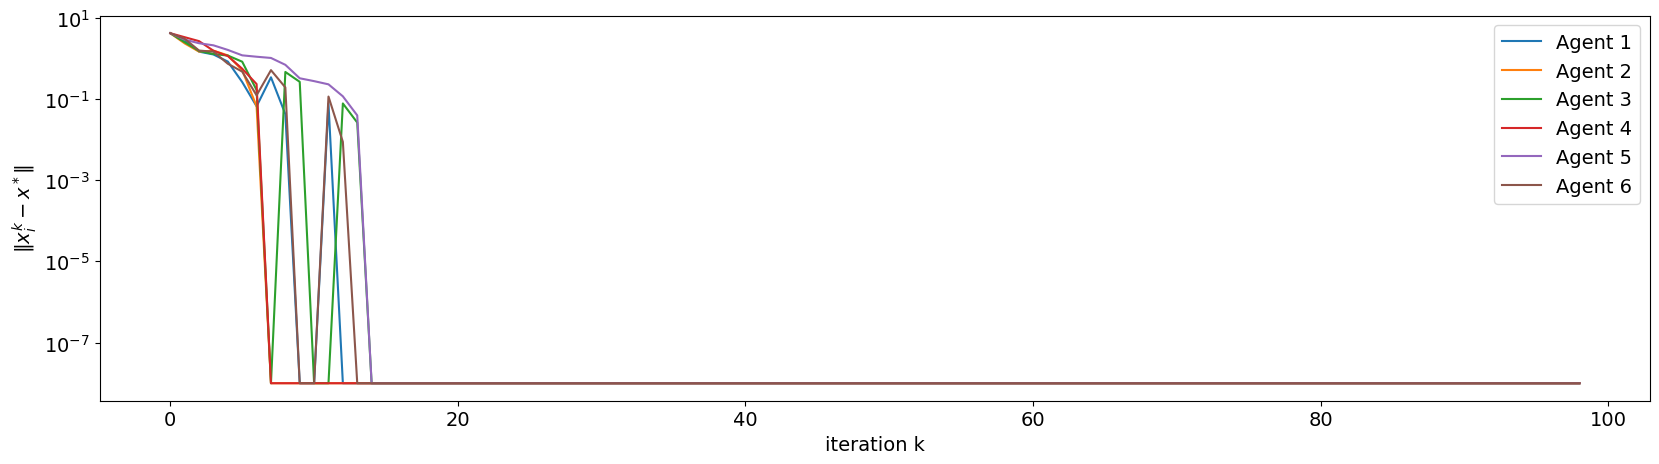

In [142]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(x_k.shape[0]-1), [np.linalg.norm(x_k[k][i] - x_opt) for k in range(x_k.shape[0]-1)], label=f"Agent {i+1}")
    
#plt.xlim(0, 100)
plt.yscale('log')
plt.legend()
#plt.title("Primal variable")
plt.xlabel("iteration k")
plt.ylabel("$\| x_i^k - x^* \|$")